In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [169]:
pob_size = 10

In [170]:
# binario a vector real
def decode_individual(bitstring: str, a: float, b: float, m: int, decimals: int) -> np.ndarray:
    dim = len(bitstring) // m
    xs = []
    max_int = 2**m - 1
    for i in range(dim):
        chunk = bitstring[i*m:(i+1)*m]
        int_val = int(chunk, 2)
        real = a + (b - a) * int_val / max_int
        xs.append(round(real, decimals))
    return np.array(xs)

# vector real a binario
def encode_individual(x: np.ndarray, a: float, b: float, m: int) -> str:
    max_int = 2**m - 1
    bits = []
    for xi in x:
        int_val = int(round((xi - a) * max_int / (b - a)))
        bits.append(format(int_val, f'0{m}b'))
    return ''.join(bits)


In [171]:
# evolucion diferencial
def de_opt(func, dim, bounds, pop_size, F, Cr, gens):
    pop = np.random.uniform(bounds[0], bounds[1], (pop_size, dim))
    for _ in range(gens):
        for i in range(pop_size):
            idxs = list(range(pop_size))
            idxs.remove(i)
            r1, r2, r3 = np.random.choice(idxs, 3, replace=False)
            x1, x2, x3 = pop[r1], pop[r2], pop[r3]
            v = x1 + F * (x2 - x3)
            jrand = np.random.randint(dim)
            u = np.array([v[j] if np.random.rand() < Cr or j == jrand else pop[i, j]
                          for j in range(dim)])
            if func(u) < func(pop[i]):
                pop[i] = u
    fitness = np.array([func(x) for x in pop])
    return pop[np.argmin(fitness)]

In [172]:
# PSO particle swarm optimization
def pso_opt(func, dim, bounds, pop_size, omega, phi_p, phi_g, iters):
    X = np.random.uniform(bounds[0], bounds[1], (pop_size, dim))
    V = np.zeros((pop_size, dim))
    pbest = X.copy()
    pbest_val = np.array([func(x) for x in X])
    gbest = pbest[np.argmin(pbest_val)].copy()

    for _ in range(iters):
        rp = np.random.rand(pop_size, dim)
        rg = np.random.rand(pop_size, dim)
        V = omega * V + phi_p * rp * (pbest - X) + phi_g * rg * (gbest - X)
        X = X + V
        X = np.clip(X, bounds[0], bounds[1])
        fX = np.array([func(x) for x in X])
        better = fX < pbest_val
        pbest[better] = X[better]
        pbest_val[better] = fX[better]
        idx = np.argmin(pbest_val)
        if pbest_val[idx] < func(gbest):
            gbest = pbest[idx].copy()

    return gbest

In [173]:
# agoritmo genetico binario
def ga_binario_opt(func, dim, bounds, m, decimales, epsilon,
                   proba_cruza, proba_muta, generaciones, etapas,
                   max_sin_mejora, t):
    pop = [''.join(random.choice('01') for _ in range(t)) for _ in range(pob_size)]
    fitness = {ind: func(decode_individual(ind, bounds[0], bounds[1], m, decimales))
               for ind in pop}
    best = min(pop, key=lambda ind: fitness[ind])
    best_val = fitness[best]
    no_improve = 0

    for gen in range(generaciones):
        new_pop = [best]
        while len(new_pop) < pob_size:
            i1, i2 = random.sample(pop, 2)
            parent1 = i1 if fitness[i1] < fitness[i2] else i2
            i3, i4 = random.sample(pop, 2)
            parent2 = i3 if fitness[i3] < fitness[i4] else i4
            if random.random() < proba_cruza:
                point = random.randrange(1, t)
                child = parent1[:point] + parent2[point:]
            else:
                child = parent1
            child = ''.join(bit if random.random() > proba_muta
                            else ('1' if bit == '0' else '0') for bit in child)
            new_pop.append(child)

        pop = new_pop
        fitness = {ind: func(decode_individual(ind, bounds[0], bounds[1], m, decimales))
                   for ind in pop}
        current = min(pop, key=lambda ind: fitness[ind])
        current_val = fitness[current]

        if current_val + epsilon < best_val:
            best, best_val = current, current_val
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= max_sin_mejora:
            break

    return decode_individual(best, bounds[0], bounds[1], m, decimales)


In [174]:
# algoritmo genetico real
def ga_real_opt(func, dim, bounds, pop_size, crossover_rate, mutation_rate, generations):
    lb, ub = bounds
    pop = np.random.uniform(lb, ub, size=(pop_size, dim))
    fitness = np.array([func(ind) for ind in pop])
    for _ in range(generations):

        best_idx = np.argmin(fitness)
        new_pop = [pop[best_idx].copy()]
        
        while len(new_pop) < pop_size:
            # torneo binario
            i1, i2 = np.random.choice(pop_size, 2, replace=False)
            parent1 = pop[i1] if fitness[i1] < fitness[i2] else pop[i2]
            i3, i4 = np.random.choice(pop_size, 2, replace=False)
            parent2 = pop[i3] if fitness[i3] < fitness[i4] else pop[i4]
            
            if np.random.rand() < crossover_rate:
                alpha = np.random.rand(dim)
                child = alpha * parent1 + (1 - alpha) * parent2
            else:
                child = parent1.copy()
            
            for k in range(dim):
                if np.random.rand() < mutation_rate:
                    child[k] += np.random.normal(0, 0.1 * (ub - lb))
            child = np.clip(child, lb, ub)
            new_pop.append(child)
        pop = np.vstack(new_pop)
        fitness = np.array([func(ind) for ind in pop])
    return pop[np.argmin(fitness)]

In [175]:
def dec_perm_cost(func_perm):
    def cost(x):
        perm = np.argsort(x)
        return func_perm(perm)
    return cost

In [176]:
# N-Reinas
def reina(perm: np.ndarray) -> int:
    N = len(perm)
    conflicts = 0
    for i in range(N):
        for j in range(i+1, N):
            if abs(perm[i] - perm[j]) == abs(i - j):
                conflicts += 1
    return conflicts

In [177]:
# TSP, travel salesman problem
coords17 = np.array([
    (565, 575), (25, 185), (345, 750), (945, 685), (845, 655), (880, 660),
    (25, 230), (525,1000), (580,1175), (650,1130), (1605,620), (1220,580),
    (1465,200), (1530,5), (845,680), (725,370), (145,665)
])
def TSP(perm: np.ndarray) -> float:
    tour = perm.astype(int)
    dist = 0.0
    for i in range(len(tour)):
        j = (i+1) % len(tour)
        dist += np.linalg.norm(coords17[tour[i]] - coords17[tour[j]])
    return dist

In [178]:
def ga_perm_opt(func, D, pop_size, generations,
                crossover_rate=0.9, mutation_rate=0.2):
    
    pop = [np.random.permutation(D) for _ in range(pop_size)]
    fitness = np.array([func(ind) for ind in pop])
    for _ in range(generations):
        best_idx = np.argmin(fitness)
        new_pop = [pop[best_idx].copy()]
        while len(new_pop) < pop_size:
            
            i1,i2 = np.random.choice(pop_size,2,replace=False)
            p1 = pop[i1] if fitness[i1]<fitness[i2] else pop[i2]
            i3,i4 = np.random.choice(pop_size,2,replace=False)
            p2 = pop[i3] if fitness[i3]<fitness[i4] else pop[i4]
            
            if np.random.rand() < crossover_rate:
                a,b = sorted(np.random.choice(D,2,replace=False))
                child = np.full(D, -1, dtype=int)
                child[a:b+1] = p1[a:b+1]
                fill = [g for g in p2 if g not in child]
                idx = 0
                for pos in list(range(0,a)) + list(range(b+1,D)):
                    child[pos] = fill[idx]; idx+=1
            else:
                child = p1.copy()
            
            if np.random.rand() < mutation_rate:
                i,j = np.random.choice(D,2,replace=False)
                child[i],child[j] = child[j],child[i]
            new_pop.append(child)
        pop = new_pop
        fitness = np.array([func(ind) for ind in pop])
    return pop[np.argmin(fitness)]

In [179]:
# parametros globales
global_pms = {
    "pob_size":      50,    # tamaño de población
    "budget":        5000  # máximo de evaluaciones   
}

its = global_pms["budget"] // global_pms["pob_size"]

# parametros de AG
ag__pms = {
    "m": 15,               # longitud del genotipo
    "decimales": 3,
    "epsilon": 1e-6,       # cota de selección
    "proba_cruza": 0.9,
    "proba_muta" : 0.1,
    "generaciones": 2,
    "etapas": 5,
    "max_sin_mejora": 50
    }

# parametros de DE
de_pms = {
    "pop_size": global_pms["pob_size"],
    "F": 0.8, 
    "Cr": 0.9, 
    "gens": its
    }

# parametros de PSO
pso_pms = {
    "pop_size": global_pms["pob_size"], 
    "omega": 0.7, 
    "phi_p":1.5, 
    "phi_g":1.5, 
    "iters": its
    }

In [180]:
# funciones 
def esfera(x):
    return np.sum(x**2)

def rosenbrock(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def himmelblau(x: np.ndarray) -> float:
    x1, x2 = x
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

def eggholder(x: np.ndarray) -> float:
    x1, x2 = x
    term1 = np.sin(np.sqrt(abs(x2 + x1/2 + 47)))
    term2 = np.sin(np.sqrt(abs(x1 - (x2 + 47))))
    return -(x2 + 47) * term1 - x1 * term2


# dicc de funciones
dicc = {
    "Esfera n=2": {
        "func": esfera,
        "dim": 2,              
        "cota": (-10, 10),   
        "m": 15,           
        "decimales" : 3
    },
    "Esfera n=5": {
        "func": esfera,
        "dim": 5,              
        "cota": (-10, 10),   
        "m": 15,           
        "decimales" : 3
    },
    "Rosenbrock n=2": {
        "func": rosenbrock,
        "dim": 2,              
        "cota": (-10, 10),   
        "m": 15,           
        "decimales" : 3
    },
    "Rosenbrock n=5": {
        "func": rosenbrock,
        "dim": 5,              
        "cota": (-10, 10),   
        "m": 15,           
        "decimales" : 3
    },
    "Himmelblau": {
        "func": himmelblau,
        "dim": 2,              
        "cota": (-5, 5),   
        "m": 14,           
        "decimales" : 3
    },
    "Eggholder": {
        "func": eggholder,
        "dim": 2,              
        "cota": (-512, 512),   
        "m": 20,           
        "decimales" : 3
    },
}

problemas = [
    ("N-Reinas", reina, 10),
    ("TSP",     TSP,     17)
]

In [181]:
# 5. Recoger historial de resultados
historial = []

for nombre, p in dicc.items():
    f, dim, bounds = p["func"], p["dim"], p["cota"]
    m = p["m"]
    decimales = p["decimales"]

    t = m * dim

    bin_pms = {
        "m":            m,
        "decimales":    decimales,
        "epsilon":      1e-6,
        "proba_cruza":  0.9,
        "proba_muta":   1/(t),
        "generaciones": its,
        "etapas":       5,
        "max_sin_mejora": 50,
        "bounds":       bounds,
        "t":            t
    }

    real_pms = {
        "pop_size":        global_pms["pob_size"],
        "crossover_rate":  0.9,
        "mutation_rate":   1/(t),
        "generations":     its
    }

    # --- AG binario ---
    vals_bin = []
    for _ in range(33):
        x_best = ga_binario_opt(f, dim, **bin_pms)
        vals_bin.append(f(x_best))

    # --- AG real ---
    vals_real = []
    for _ in range(33):
        x_best = ga_real_opt(f, dim, bounds, **real_pms)
        vals_real.append(f(x_best))

    # --- ED ---
    vals_de = []
    for _ in range(33):
        x_best = de_opt(f, dim, bounds, **de_pms)
        vals_de.append(f(x_best))

    # --- PSO ---
    vals_pso = []
    for _ in range(33):
        x_best = pso_opt(f, dim, bounds, **pso_pms)
        vals_pso.append(f(x_best))

    
    for alg, vals in [("AG_binario", vals_bin), 
                      ("AG_real", vals_real), 
                      ("ED", vals_de), 
                      ("PSO", vals_pso)]:
        historial.append({
            "Problema": nombre,
            "Algoritmo": alg,
            "Mejor":  np.min(vals),
            "Media":  np.mean(vals),
            "Std":    np.std(vals)
        })


df = pd.DataFrame(historial)
df_pivot = df.pivot_table(
    index="Problema",
    columns="Algoritmo",
    values=["Mejor","Media","Std"]
)

df_pivot.columns = [f"{metric}_{alg}" for metric, alg in df_pivot.columns]

display(
    df_pivot.style
        .format("{:.2e}")
        .set_caption("Comparación 33 experimentos")
)


,Media_AG_binario,Media_AG_real,Media_ED,Media_PSO,Mejor_AG_binario,Mejor_AG_real,Mejor_ED,Mejor_PSO,Std_AG_binario,Std_AG_real,Std_ED,Std_PSO
Problema,,,,,,,,,,,,
Eggholder,-8.16e+02,-7.79e+02,-2.72e+18,-9.15e+02,-9.60e+02,-9.56e+02,-3.51e+19,-9.60e+02,1.18e+02,1.19e+02,6.26e+18,7.08e+01
Esfera n=2,1.21e-06,3.33e-06,1.18e-18,3.60e-13,0.00e+00,7.52e-23,1.72e-21,5.02e-15,1.95e-06,1.20e-05,2.11e-18,6.54e-13
Esfera n=5,2.69e-02,3.62e-03,3.23e-04,6.97e-09,1.00e-06,1.22e-05,5.45e-05,4.23e-10,9.44e-02,4.94e-03,2.44e-04,8.50e-09
Himmelblau,7.82e-01,1.16e-03,6.93e-08,2.32e-12,1.70e-05,0.00e+00,1.77e-16,5.03e-16,1.60e+00,3.07e-03,3.87e-07,4.59e-12
Rosenbrock n=2,2.72e+00,6.85e-02,2.72e-09,9.55e-06,4.92e-05,1.12e-07,3.99e-15,7.00e-10,3.71e+00,1.45e-01,1.40e-08,3.56e-05
Rosenbrock n=5,1.19e+02,5.84e+00,3.24e+00,2.04e+00,3.81e+00,1.65e+00,6.32e-01,6.75e-02,2.41e+02,7.61e+00,1.34e+00,2.32e+00


,Problema,Algoritmo,Solución,Valor
0,N-Reinas,AG_bin,"4,2,9,6,1,5,8,0,7,3",0.000000
1,N-Reinas,ED,"5,1,9,6,8,2,0,3,7,4",0.000000
2,N-Reinas,PSO,"2,7,3,1,9,8,5,0,4,6",1.000000
3,N-Reinas,AG_real,"6,2,5,1,9,0,8,4,7,3",0.000000
4,TSP,AG_bin,"10,12,13,15,0,1,6,16,2,7,8,9,14,4,5,3,11",5048.449187
5,TSP,ED,"5,13,12,10,11,3,14,4,15,0,1,6,16,2,7,8,9",5424.532933
6,TSP,PSO,"11,10,12,13,15,0,14,4,5,3,6,1,16,2,7,8,9",5758.559222
7,TSP,AG_real,"7,8,9,10,12,13,11,3,5,14,4,15,0,1,6,16,2",5337.137890


<Figure size 800x400 with 0 Axes>

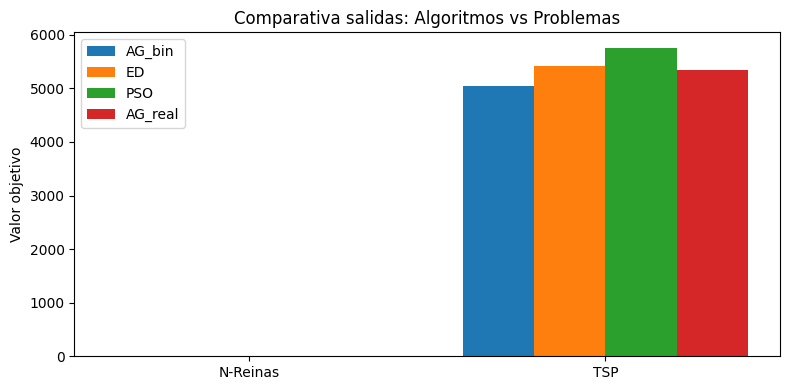

In [182]:
records = []
for name, func_perm, D in problemas:
    # AG binario
    sol_perm = ga_perm_opt(func_perm, D, global_pms["pob_size"], its)
    val_perm = func_perm(sol_perm)
    sol_str_perm = ",".join(map(str, sol_perm))
    records.append({"Problema":name, "Algoritmo":"AG_bin", "Solución":sol_str_perm, "Valor":val_perm})
    # ED
    cost = dec_perm_cost(func_perm)
    sol_de = de_opt(cost, D, (0,1), global_pms["pob_size"], 0.8, 0.9, its)
    perm_de = sol_de.argsort()
    val_de = func_perm(perm_de)
    records.append({"Problema":name, "Algoritmo":"ED", "Solución":",".join(map(str,perm_de)), "Valor":val_de})
    # PSO
    sol_pso = pso_opt(cost, D, (0,1), global_pms["pob_size"], 0.7,1.5,1.5,its)
    perm_pso = sol_pso.argsort(); val_pso = func_perm(perm_pso)
    records.append({"Problema":name, "Algoritmo":"PSO", "Solución":",".join(map(str,perm_pso)), "Valor":val_pso})
    # AG real
    sol_real = ga_real_opt(cost, D, (0,1), global_pms["pob_size"], 0.9, 0.2, its)
    perm_real = sol_real.argsort(); val_real = func_perm(perm_real)
    records.append({"Problema":name, "Algoritmo":"AG_real","Solución":",".join(map(str,perm_real)),"Valor":val_real})


df_out = pd.DataFrame(records)
display(df_out)

# grafica
plt.figure(figsize=(8,4))
for i,(name, group) in enumerate(df_out.groupby("Problema")):
    vals = group["Valor"].values
    algs = group["Algoritmo"].values
    x = np.arange(len(algs)) + i*(len(algs)+1)
    plt.bar(x, vals, label=name)
plt.xticks(
    [i*(len(algs)+1)+len(algs)/2-0.5 for i in range(len(problemas)) for _ in [0]],
    problemas
)

n_alg = len(records)//len(problemas)
x = np.arange(len(problemas))
width = 0.8 / n_alg
plt.clf()
fig, ax = plt.subplots(figsize=(8,4))
alg_list = ["AG_bin","ED","PSO","AG_real"]
for j, alg in enumerate(alg_list):
    vals = [ df_out[(df_out["Problema"]==name)&(df_out["Algoritmo"]==alg)]["Valor"].values[0] for name in [p[0] for p in problemas] ]
    ax.bar(x + j*width, vals, width, label=alg)
ax.set_xticks(x + width*(len(alg_list)-1)/2)
ax.set_xticklabels([p[0] for p in problemas])
ax.set_ylabel("Valor objetivo")
ax.set_title("Comparativa salidas: Algoritmos vs Problemas")
ax.legend()
plt.tight_layout()
plt.show()